In [ ]:
import pandas as pd

In [41]:
data = {
    "color": ["red", "blue", "green", "blue", "red"],
    "city": ["Berlin", "Paris", "Berlin", "London", "Paris"],
    "value": [10, 20, 15, 30, 25]
}
df_test = pd.DataFrame(data)
print(df_test)



   color    city  value
0    red  Berlin     10
1   blue   Paris     20
2  green  Berlin     15
3   blue  London     30
4    red   Paris     25


In [62]:
df = pd.read_csv('../data/train.csv')
df['heatingType'].value_counts(dropna=False)

heatingType
central_heating                   133
NaN                                75
floor_heating                      36
gas_heating                        29
district_heating                   23
self_contained_central_heating     17
oil_heating                        13
heat_pump                           8
electric_heating                    7
combined_heat_and_power_plant       4
wood_pellet_heating                 1
Name: count, dtype: int64

In [68]:
df

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date,americanArea
0,Nordrhein_Westfalen,235.00,central_heating,NaN,NaN,False,True,8,5.13,NaN,...,Handorf,Ruhig und hell! Wohnen auf 100 m²: 2-Raum-Wohn...,NaN,NaN,F,NaN,NaN,NaN,May19,1076.390000
1,Nordrhein_Westfalen,180.00,heat_pump,NaN,NaN,True,True,18,4.98,NaN,...,Wolbeck,Die angebotene Wohnung im 1. Obergeschoss ist ...,Bei diesem Mehrfamilienhaus / dieser Wohnung f...,80.0,A_PLUS,NaN,NaN,NaN,Oct19,942.487084
2,Nordrhein_Westfalen,140.00,gas_heating,ONE_YEAR_FREE,NaN,False,True,6,6.67,40.0,...,Kinderhaus_West,Die 3 Zimmer Wohnung befindet sich in der erst...,Die Wohnung ist mit neuem Laminat ausgestattet...,90.0,NaN,NaN,90.76,0.1915,Sep18,826.129325
3,Nordrhein_Westfalen,180.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,False,1,6.93,10.0,...,Pluggendorf,Dieses mit langer und wechselhafter Geschichte...,Das immer wieder liebevoll sanierte Haus (im z...,NaN,NaN,2013.0,90.76,0.1915,Sep18,828.820300
4,Nordrhein_Westfalen,170.00,NaN,ONE_YEAR_FREE,NaN,True,True,19,6.81,40.0,...,Gremmendorf_West,Sie sind interessiert an ruhigem Wohnen mit Ba...,• verfügbar ab dem 01.12.2018 • Küche kann übe...,NaN,NaN,NaN,90.76,0.1915,Sep18,914.931500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,Nordrhein_Westfalen,160.00,floor_heating,NaN,NaN,False,True,12,4.89,NaN,...,Hiltrup_West,Bei dieser 3-Zimmer-Wohnung im Erdgeschoss (Ne...,Die gesamte Wohnung verfügt über eine sehr geh...,NaN,NaN,NaN,NaN,NaN,Oct19,871.875900
342,Nordrhein_Westfalen,440.00,district_heating,ONE_YEAR_FREE,10.0,False,True,11,4.50,10.0,...,Buddenturm,Diese repräsentative Wohnung liegt im Gebäude ...,NaN,NaN,NaN,NaN,NaN,NaN,Oct19,1582.293300
343,Nordrhein_Westfalen,315.00,central_heating,ONE_YEAR_FREE,NaN,False,True,19,6.17,40.0,...,Gievenbeck,Diese sehr ruhig gelegene 4-Zimmer-Wohnung in ...,Die helle Wohnung mit weißen Holztüren und Ede...,NaN,NaN,2020.0,NaN,NaN,Feb20,1534.932140
344,Nordrhein_Westfalen,513.04,district_heating,ONE_YEAR_FREE,NaN,True,True,2,4.90,40.0,...,Aaseestadt,Bei dieser ansprechenden Immobilie handelt es ...,"Barrierearm, Einbauküche: Spülmaschine, Backof...",NaN,NaN,NaN,NaN,NaN,Feb20,1442.362600


In [42]:
def col_encoder(df: pd.DataFrame, col: str) -> tuple[pd.DataFrame, dict]:
    df[col], mapping = pd.factorize(df_test[col])

    return df, dict(enumerate(mapping))

In [ ]:
df, mapping = col_encoder(df_test, 'color')
df

,color,city,value
0,0,Berlin,10
1,1,Paris,20
2,2,Berlin,15
3,1,London,30
4,0,Paris,25


In [44]:
df.select_dtypes(exclude='number').columns.to_numpy()


array(['regio1', 'heatingType', 'telekomTvOffer', 'newlyConst', 'balcony',
       'firingTypes', 'hasKitchen', 'geo_bln', 'cellar', 'houseNumber',
       'geo_krs', 'condition', 'interiorQual', 'petsAllowed', 'street',
       'streetPlain', 'lift', 'typeOfFlat', 'garden', 'regio2', 'regio3',
       'description', 'facilities', 'energyEfficiencyClass', 'date'],
      dtype=object)

In [65]:
none_num_cols = ['heatingType', 'telekomTvOffer', 'newlyConst', 'balcony',
        'firingTypes', 'hasKitchen', 'cellar', 'condition', 'interiorQual', 'petsAllowed',
        'lift', 'typeOfFlat', 'garden', 'energyEfficiencyClass']

In [72]:
df['heatingType']

0                     central_heating
1                           heat_pump
2                         gas_heating
3      self_contained_central_heating
4                                 NaN
                    ...              
341                     floor_heating
342                  district_heating
343                   central_heating
344                  district_heating
345                   central_heating
Name: heatingType, Length: 346, dtype: object

In [71]:
col_encoder(df, 'heatingType')

KeyError: 'heatingType'

In [69]:
dict_of_mappings = {}
for col in none_num_cols:
    df, mapping = col_encoder(df, col)
    dict_of_mappings[col] = mapping


df


    

KeyError: 'heatingType'

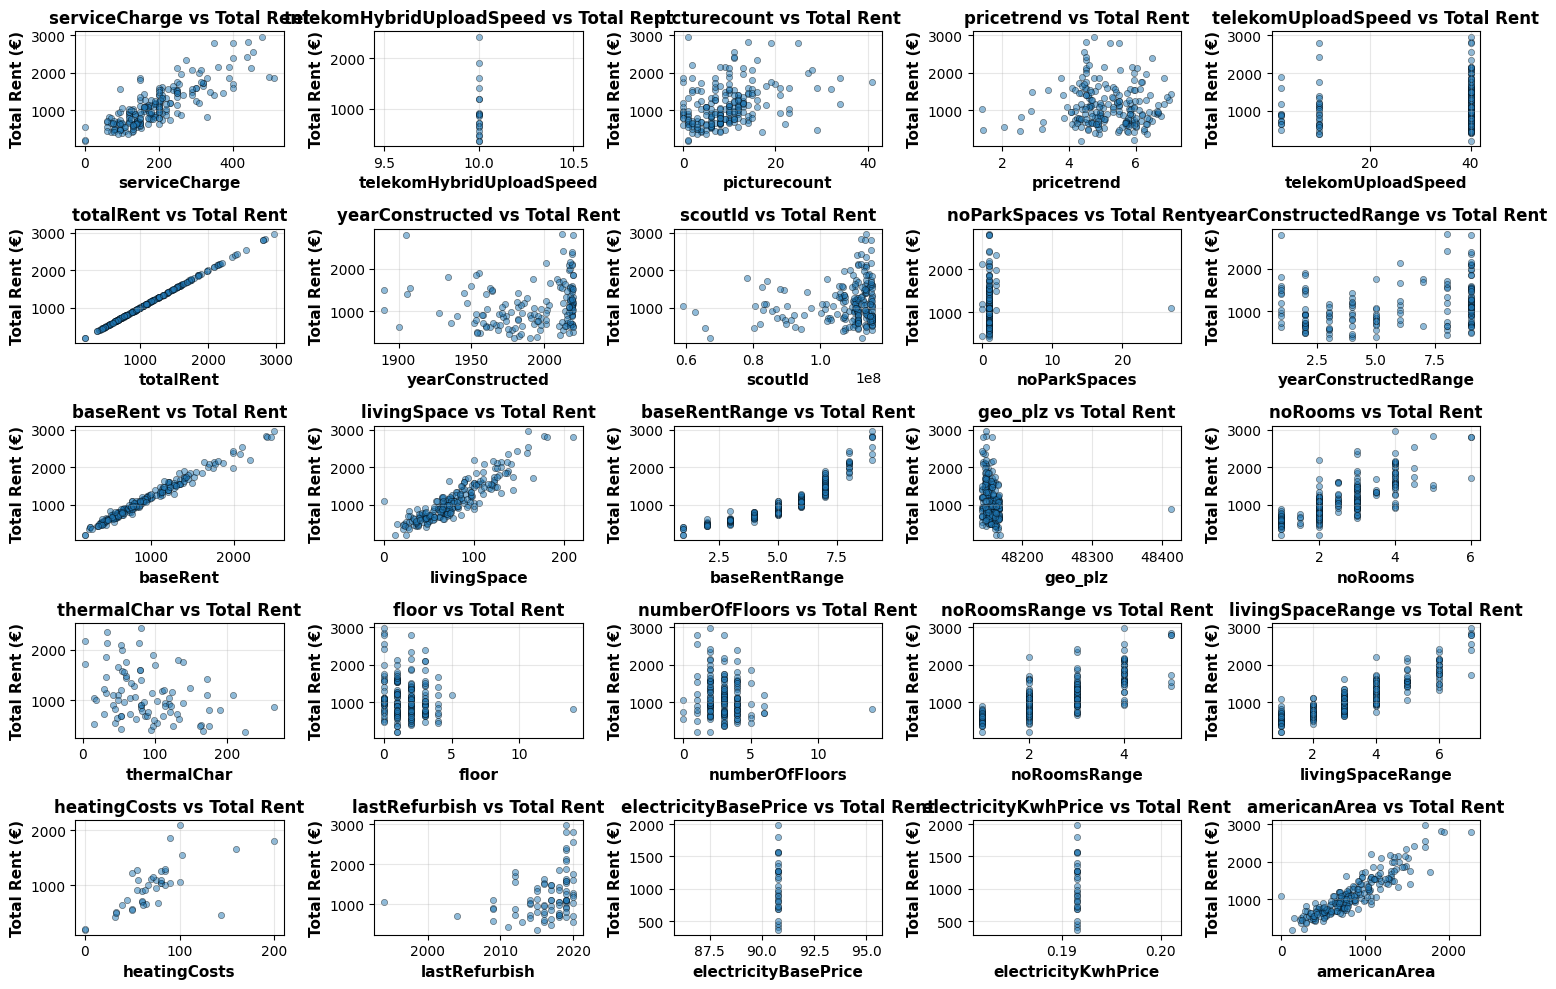

In [25]:
import matplotlib.pyplot as plt

# Select numerical features for visualization
numerical_features = df.select_dtypes(include='number').columns.to_numpy()
target = 'totalRent'


# Create a grid of scatter plots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    
    # Create scatter plot
    ax.scatter(df[feature], df[target], alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
    ax.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Total Rent (€)', fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} vs Total Rent', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()